# Packages and global variables

In [1]:
%matplotlib inline

In [2]:
import warnings
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy
from scipy import stats
from scipy.special import comb

import seaborn as sns
import matplotlib.pyplot as plt

import flowanalysis.definitions as fa

In [3]:
required_directories = [
    "Data/",
    "ANOVA/WT/",
    "ANOVA/N3A/",
    "ANOVA/T8A/",
    "ANOVA/Data/",
    "Fig-Venn/",
    "Fig-Slopes/",
    "Fig-Correlations/",
]
for directory in required_directories:
    os.makedirs(os.path.dirname(directory), exist_ok=True)

In [4]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True})
plt.rcParams["text.latex.preamble"] = r"\usepackage{graphicx}"
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

absolute_numbers = False
mean_only_venn = True

stats_challenges = ("Memory", "WT challenge", "T8A challenge", "N3A challenge")
time_names = ("Primary", "Memory", "WT challenge", "T8A challenge", "N3A challenge")
naive_columns = ("WT column", "T8A column", "N3A column")
tetramer_names = ("WT", "T8A", "N3A")
naive_stats_column_names = (
    "SP [WT]",
    "T8A [WT]",
    "N3A [WT]",
    "TP [WT]",
    "SP [T8A]",
    "WT [T8A]",
    "N3A [T8A]",
    "TP [T8A]",
    "SP [N3A]",
    "WT [N3A]",
    "T8A [N3A]",
    "TP [N3A]",
)

# Venn and slope plots
## Spleen
### Circulating

In [5]:
fa.header_clipping("WT", check=True)
fa.header_clipping("T8A", check=True)
fa.header_clipping("N3A", check=True)

['Mouse', 'Cell_Count', 'Tissue', 'Condition', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'F480 B220 Negative', 'CD8p_Freq', 'CD8p_Norm_Freq', 'CD8p_Num', 'CD8p_N3ATotal_Freq', 'CD8p_N3ATotal_Num', 'CD8p_T8ATotal_Freq', 'CD8p_T8ATotal_Num', 'CD8p_WTTotal_Freq', 'CD8p_WTTotal_Num', 'CD8p_TriplePos_Freq', 'CD8p_TriplePos_Num', 'CD8p_N3AT8ADP_Freq', 'CD8p_N3AT8ADP_Num', 'CD8p_WTN3ADP_Freq', 'CD8p_WTN3ADP_Num', 'CD8p_WTT8ADP_Freq', 'CD8p_WTT8ADP_Num', 'WTSP_Freq', 'WTSP_Num', 'N3ASP_Freq', 'N3ASP_Num', 'T8ASP_Freq', 'T8ASP_Num']
['Mouse', 'Cell Count', 'Tissue', 'T8A Primary', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'F480 B220 Negative', 'CD8p_Freq', 'CD8p_Norm_Freq', 'CD8p_Num', 'CD8p_N3ATotal_Freq', 'CD8p_N3ATotal_Num', 'CD8p_T8ATotal_Freq', 'CD8p_T8ATotal_Num', 'CD8p_WTTotal_Freq', 'CD8p_WTTotal_Num', 'CD8p_TriplePos_Freq', 'CD8p_TriplePos_Num', 'CD8p_N3AT8ADP_Freq', 'CD8p_N3AT8ADP_Num', 'CD8p_WTN3ADP_Freq', 'CD8p_WTN3ADP_Num', 'CD8p_WTT8ADP_Freq', 'CD8p_WTT8ADP_Num

In [6]:
fa.header_clipping("WT")
fa.header_clipping("T8A")
fa.header_clipping("N3A")

wt_p_headers = [
    "Tissue",
    "Condition",
    "WTSP_Num",
    "T8ASP_Num",
    "N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8p_Num",
]
t8a_p_headers = [
    "Tissue",
    "T8A Primary",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8p_Num",
]
n3a_p_headers = [
    "Tissue",
    "Infection",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_N3AWTDP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8+CD45-_Norm_Num",
]

wt_p_time_names = fa.time_name_list("WT", wt_p_headers)
t8a_p_time_names = fa.time_name_list("T8A", t8a_p_headers)
n3a_p_time_names = fa.time_name_list("N3A", n3a_p_headers)

wt_spleen_cir_exp = fa.data_extraction(
    "WT",
    "spleen",
    wt_p_headers,
    wt_p_time_names,
    standard_names=time_names,
    timepoints=5,
)
t8a_spleen_cir_exp = fa.data_extraction(
    "T8A",
    "spleen",
    t8a_p_headers,
    t8a_p_time_names,
    standard_names=time_names,
    timepoints=5,
)
n3a_spleen_cir_exp = fa.data_extraction(
    "N3A",
    "spleen",
    n3a_p_headers,
    n3a_p_time_names,
    standard_names=time_names,
    timepoints=5,
)

#### Venn plots

In [7]:
wt_spleen_cir_exp.venn_plot(
    "Fig-Venn/V-WT-S-Cir", frequency=False, mean_only=mean_only_venn
)
wt_spleen_cir_exp.venn_plot(
    "Fig-Venn/V-WT-S-Cir-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [8]:
t8a_spleen_cir_exp.venn_plot(
    "Fig-Venn/V-T8A-S-Cir", frequency=False, mean_only=mean_only_venn
)
t8a_spleen_cir_exp.venn_plot(
    "Fig-Venn/V-T8A-S-Cir-F", frequency=True, labels=False, mean_only=mean_only_venn
)

/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


In [9]:
n3a_spleen_cir_exp.venn_plot(
    "Fig-Venn/V-N3A-S-Cir", frequency=False, mean_only=mean_only_venn
)
n3a_spleen_cir_exp.venn_plot(
    "Fig-Venn/V-N3A-S-Cir-F", frequency=True, labels=False, mean_only=mean_only_venn
)

/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


#### Slopes

In [10]:
wt_spleen_cir_exp.slope_plot("Fig-Slopes/L-WT-S-Cir")

In [11]:
t8a_spleen_cir_exp.slope_plot("Fig-Slopes/L-T8A-S-Cir")

In [12]:
n3a_spleen_cir_exp.slope_plot("Fig-Slopes/L-N3A-S-Cir")

### Resident

In [13]:
fa.header_clipping("WT", cd45="-", check=True)
fa.header_clipping("T8A", cd45="-", check=True)
fa.header_clipping("N3A", cd45="-", check=True)

['Mouse', 'Cell Count', 'Tissue', 'Condition', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'F480 B220 Negative', 'CD8n_Freq', 'CD8n_Norm_Freq', 'CD8n_Num', 'CD8n_N3ATotal_Freq', 'CD8n_N3ATotal_Num', 'CD8n_T8ATotal_Freq', 'CD8n_T8Atotal_Num', 'CD8n_WTTotal_Freq', 'CD8n_WTTotal_Num', 'CD8n_Triplepos_Freq', 'CD8n_Triplepos_Num', 'CD8n_N3AT8ADP_Freq', 'CD8n_N3AT8ADP_Num', 'CD8n_WTN3ADP_Freq', 'CD8n_WTN3ADP_Num', 'CD8n_WTT8ADP_Freq', 'CD8n_WTT8ADP_Num', 'CD8n_WTSP_Freq', 'CD8n_WTSP_Num', 'CD8n_N3ASP_Freq', 'CD8n_N3ASP_Num', 'CD8n_T8ASP_Freq', 'CD8n_T8ASP_Num', 'Triple Neg', 'total frequency tet+ cells']
['Mouse', 'Cell Count', 'Tissue', 'Infection', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'F480 B220 Negative', 'CD8n_Freq', 'CD8n_Norm_Freq', 'CD8n_Num', 'CD8n_N3A_Total_Freq', 'CD8n_N3A_Total_Num', 'CD8n_T8ATotalFreq', 'CD8p_T8ATotal_Num', 'CD8p_WTTotal_Freq', 'CD8p_WTTotal_Num', 'CD8p_TriplePos_Freq', 'CD8p_TriplePos_Num', 'CD8p_N3AT8ADP_Freq', 'CD8p_N3AT8ADP_Num', 'CD8p_

In [14]:
fa.header_clipping("WT", cd45="-")
fa.header_clipping("T8A", cd45="-")
fa.header_clipping("N3A", cd45="-")

wt_n_headers = [
    "Tissue",
    "Condition",
    "CD8n_WTSP_Num",
    "CD8n_T8ASP_Num",
    "CD8n_N3ASP_Num",
    "CD8n_WTT8ADP_Num",
    "CD8n_WTN3ADP_Num",
    "CD8n_N3AT8ADP_Num",
    "CD8n_Triplepos_Num",
    "CD8n_Num",
]
t8a_n_headers = [
    "Tissue",
    "Infection",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8n_Num",
]
n3a_n_headers = [
    "Tissue",
    "Infection",
    "CD8n_WTSP_Num",
    "CD8n_T8ASP_Num",
    "CD8n_N3ASP_Num",
    "CD8n_WTT8ADP_Num",
    "CD8n_N3AWTDP_Num",
    "CD8n_N3AT8ADP_Num",
    "CD8n_TriplePos_Num",
    "CD8+CD45-_Norm_Num",
]

wt_n_time_names = fa.time_name_list("WT", wt_n_headers, cd45="-")
t8a_n_time_names = fa.time_name_list("T8A", t8a_n_headers, cd45="-")
n3a_n_time_names = fa.time_name_list("N3A", n3a_n_headers, cd45="-")

wt_spleen_res_exp = fa.data_extraction(
    "WT",
    "spleen",
    wt_n_headers,
    wt_n_time_names,
    standard_names=time_names,
    cd45="-",
    timepoints=5,
)
t8a_spleen_res_exp = fa.data_extraction(
    "T8A",
    "spleen",
    t8a_n_headers,
    t8a_n_time_names,
    standard_names=time_names,
    cd45="-",
    timepoints=5,
)
n3a_spleen_res_exp = fa.data_extraction(
    "N3A",
    "spleen",
    n3a_n_headers,
    n3a_n_time_names,
    standard_names=time_names,
    cd45="-",
    timepoints=5,
)

#### Venn plots

In [15]:
wt_spleen_res_exp.venn_plot(
    "Fig-Venn/V-WT-S-Res", frequency=False, mean_only=mean_only_venn
)
wt_spleen_res_exp.venn_plot(
    "Fig-Venn/V-WT-S-Res-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [16]:
t8a_spleen_res_exp.venn_plot(
    "Fig-Venn/V-T8A-S-Res", frequency=False, mean_only=mean_only_venn
)
t8a_spleen_res_exp.venn_plot(
    "Fig-Venn/V-T8A-S-Res-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [17]:
n3a_spleen_res_exp.venn_plot(
    "Fig-Venn/V-N3A-S-Res", frequency=False, mean_only=mean_only_venn
)
n3a_spleen_res_exp.venn_plot(
    "Fig-Venn/V-N3A-S-Res-F", frequency=True, labels=False, mean_only=mean_only_venn
)

#### Slopes

In [18]:
wt_spleen_res_exp.slope_plot("Fig-Slopes/L-WT-S-Res")

In [19]:
t8a_spleen_res_exp.slope_plot("Fig-Slopes/L-T8A-S-Res")

In [20]:
n3a_spleen_res_exp.slope_plot("Fig-Slopes/L-N3A-S-Res")

## Lungs
### Circulating

In [21]:
fa.header_clipping("WT")
fa.header_clipping("T8A")
fa.header_clipping("N3A")

wt_p_headers = [
    "Tissue",
    "Condition",
    "WTSP_Num",
    "T8ASP_Num",
    "N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8p_Num",
]
t8a_p_headers = [
    "Tissue",
    "T8A Primary",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8p_Num",
]
n3a_p_headers = [
    "Tissue",
    "Infection",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_N3AWTDP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8+CD45-_Norm_Num",
]

wt_p_time_names = fa.time_name_list("WT", wt_p_headers)
t8a_p_time_names = fa.time_name_list("T8A", t8a_p_headers)
n3a_p_time_names = fa.time_name_list("N3A", n3a_p_headers)

wt_lungs_cir_exp = fa.data_extraction(
    "WT",
    "lungs",
    wt_p_headers,
    wt_p_time_names,
    standard_names=time_names,
    timepoints=5,
)
t8a_lungs_cir_exp = fa.data_extraction(
    "T8A",
    "lungs",
    t8a_p_headers,
    t8a_p_time_names,
    standard_names=time_names,
    timepoints=5,
)
n3a_lungs_cir_exp = fa.data_extraction(
    "N3A",
    "lungs",
    n3a_p_headers,
    n3a_p_time_names,
    standard_names=time_names,
    timepoints=5,
)

#### Venn plots

In [22]:
wt_lungs_cir_exp.venn_plot(
    "Fig-Venn/V-WT-L-Cir", frequency=False, mean_only=mean_only_venn
)
wt_lungs_cir_exp.venn_plot(
    "Fig-Venn/V-WT-L-Cir-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [23]:
t8a_lungs_cir_exp.venn_plot(
    "Fig-Venn/V-T8A-L-Cir", frequency=False, mean_only=mean_only_venn
)
t8a_lungs_cir_exp.venn_plot(
    "Fig-Venn/V-T8A-L-Cir-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [24]:
n3a_lungs_cir_exp.venn_plot(
    "Fig-Venn/V-N3A-L-Cir", frequency=False, mean_only=mean_only_venn
)
n3a_lungs_cir_exp.venn_plot(
    "Fig-Venn/V-N3A-L-Cir-F", frequency=True, labels=False, mean_only=mean_only_venn
)

#### Slopes

In [25]:
wt_lungs_cir_exp.slope_plot("Fig-Slopes/L-WT-L-Cir")

In [26]:
t8a_lungs_cir_exp.slope_plot("Fig-Slopes/L-T8A-L-Cir")

In [27]:
n3a_lungs_cir_exp.slope_plot("Fig-Slopes/L-N3A-L-Cir")

### Resident

In [28]:
fa.header_clipping("WT", cd45="-")
fa.header_clipping("T8A", cd45="-")
fa.header_clipping("N3A", cd45="-")

wt_n_headers = [
    "Tissue",
    "Condition",
    "CD8n_WTSP_Num",
    "CD8n_T8ASP_Num",
    "CD8n_N3ASP_Num",
    "CD8n_WTT8ADP_Num",
    "CD8n_WTN3ADP_Num",
    "CD8n_N3AT8ADP_Num",
    "CD8n_Triplepos_Num",
    "CD8n_Num",
]
t8a_n_headers = [
    "Tissue",
    "Infection",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8n_Num",
]
n3a_n_headers = [
    "Tissue",
    "Infection",
    "CD8n_WTSP_Num",
    "CD8n_T8ASP_Num",
    "CD8n_N3ASP_Num",
    "CD8n_WTT8ADP_Num",
    "CD8n_N3AWTDP_Num",
    "CD8n_N3AT8ADP_Num",
    "CD8n_TriplePos_Num",
    "CD8+CD45-_Norm_Num",
]

wt_n_time_names = fa.time_name_list("WT", wt_n_headers, cd45="-")
t8a_n_time_names = fa.time_name_list("T8A", t8a_n_headers, cd45="-")
n3a_n_time_names = fa.time_name_list("N3A", n3a_n_headers, cd45="-")

wt_lungs_res_exp = fa.data_extraction(
    "WT",
    "lungs",
    wt_n_headers,
    wt_n_time_names,
    standard_names=time_names,
    cd45="-",
    timepoints=5,
)
t8a_lungs_res_exp = fa.data_extraction(
    "T8A",
    "lungs",
    t8a_n_headers,
    t8a_n_time_names,
    standard_names=time_names,
    cd45="-",
    timepoints=5,
)
n3a_lungs_res_exp = fa.data_extraction(
    "N3A",
    "lungs",
    n3a_n_headers,
    n3a_n_time_names,
    standard_names=time_names,
    cd45="-",
    timepoints=5,
)

#### Venn plots

In [29]:
wt_lungs_res_exp.venn_plot(
    "Fig-Venn/V-WT-L-Res", frequency=False, mean_only=mean_only_venn
)
wt_lungs_res_exp.venn_plot(
    "Fig-Venn/V-WT-L-Res-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [30]:
t8a_lungs_res_exp.venn_plot(
    "Fig-Venn/V-T8A-L-Res", frequency=False, mean_only=mean_only_venn
)
t8a_lungs_res_exp.venn_plot(
    "Fig-Venn/V-T8A-L-Res-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [31]:
n3a_lungs_res_exp.venn_plot(
    "Fig-Venn/V-N3A-L-Res", frequency=False, mean_only=mean_only_venn
)
n3a_lungs_res_exp.venn_plot(
    "Fig-Venn/V-N3A-L-Res-F", frequency=True, labels=False, mean_only=mean_only_venn
)

#### Slopes

In [32]:
wt_lungs_res_exp.slope_plot("Fig-Slopes/L-WT-L-Res")

In [33]:
t8a_lungs_res_exp.slope_plot("Fig-Slopes/L-T8A-L-Res")

In [34]:
n3a_lungs_res_exp.slope_plot("Fig-Slopes/L-N3A-L-Res")

# Stats
## WT Priming
### Spleen
#### Circulating

In [35]:
wt_spleen_cir_df = wt_spleen_cir_exp.to_df(
    file_name="ANOVA/Data/WT-S-Cir", frequency=False
)
wt_spleen_cir_df_feq = wt_spleen_cir_exp.to_df(file_name="ANOVA/Data/WT-S-Cir-F")

In [36]:
wt_spleen_cir_exp.combined_correlation_plot(
    "Fig-Correlations/S-WT-S-Cir",
    timepoints=stats_challenges,
)
for challenge in stats_challenges:
    wt_spleen_cir_exp.correlation_plot(
        challenge,
        file_name=f"Fig-Correlations/S-WT-{challenge.split(' ')[0]}-S-Cir",
    )

#### Resident

In [37]:
wt_spleen_res_df = wt_spleen_res_exp.to_df(
    file_name="ANOVA/Data/WT-S-Res", frequency=False
)
wt_spleen_res_df_feq = wt_spleen_res_exp.to_df(file_name="ANOVA/Data/WT-S-Res-F")

In [38]:
wt_spleen_res_exp.combined_correlation_plot(
    "Fig-Correlations/S-WT-S-Res",
    timepoints=stats_challenges,
)
for challenge in stats_challenges:
    wt_spleen_res_exp.correlation_plot(
        challenge,
        file_name=f"Fig-Correlations/S-WT-{challenge.split(' ')[0]}-S-Res",
    )

### Lungs
#### Circulating

In [39]:
wt_lungs_cir_df = wt_lungs_cir_exp.to_df(
    file_name="ANOVA/Data/WT-L-Cir", frequency=False
)
wt_lungs_cir_df_freq = wt_lungs_cir_exp.to_df(file_name="ANOVA/Data/WT-L-Cir-F")

In [40]:
wt_lungs_cir_exp.combined_correlation_plot(
    "Fig-Correlations/S-WT-L-Cir",
    timepoints=stats_challenges,
)
for challenge in stats_challenges:
    wt_lungs_cir_exp.correlation_plot(
        challenge,
        file_name=f"Fig-Correlations/S-WT-{challenge.split(' ')[0]}-L-Cir",
    )

#### Resident

In [41]:
wt_lungs_res_df = wt_lungs_res_exp.to_df(
    file_name="ANOVA/Data/WT-L-Res", frequency=False
)
wt_lungs_res_df_freq = wt_lungs_res_exp.to_df(file_name="ANOVA/Data/WT-L-Res-F")

In [42]:
wt_lungs_res_exp.combined_correlation_plot(
    "Fig-Correlations/S-WT-L-Res",
    timepoints=stats_challenges,
)
for challenge in stats_challenges:
    wt_lungs_res_exp.correlation_plot(
        challenge,
        file_name=f"Fig-Correlations/S-WT-{challenge.split(' ')[0]}-L-Res",
    )

## Correlation heatmaps

In [92]:
from scipy import stats
import numpy as np
import warnings


def _spearman_pval(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("error")
        try:
            return stats.spearmanr(x, y)[1]
        except stats.SpearmanRConstantInputWarning:
            return 1


def _asterisk_significance(pval, comparisons=None):

    if comparisons is None:
        comparisons = 1

    if pval <= 0.01 / comparisons:
        return "${\\ast}{\\ast}$"
    elif pval <= 0.05 / comparisons:
        return "${\\ast}$"
    else:
        return ""


test = (
    wt_lungs_res_df[(wt_lungs_res_df.Challenge == "Memory")]
    .corr(method=_spearman_pval)
    .applymap(_asterisk_significance)
)  # - np.eye(len(wt_lungs_cir_df.columns) - 1)

# test.applymap(_asterisk_significance)

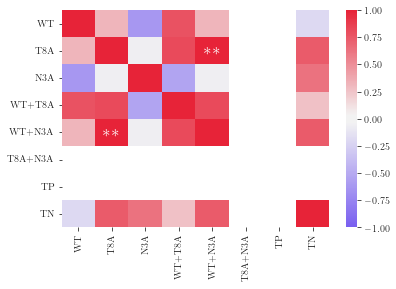

In [97]:
sns.heatmap(
    wt_lungs_res_df[(wt_lungs_res_df.Challenge == "Memory")].corr(method="spearman"),
    vmin=-1,
    vmax=1,
    cmap=sns.diverging_palette(270, 10, s=90, sep=10, as_cmap=True),
    # cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True),
    # cmap=sns.color_palette("vlag", as_cmap=True),
    annot=wt_lungs_res_df[(wt_lungs_res_df.Challenge == "Memory")]
    .corr(method=_spearman_pval)
    .applymap(_asterisk_significance),
    fmt="",
    annot_kws={
        "size": "xx-large",
        # "color": "k",
    },
)
plt.savefig("TEST.pdf")

In [69]:
from scipy import stats
import numpy as np

wt_lungs_res_df[(wt_lungs_res_df.Challenge == "Memory")].corr(
    method="spearman"
) - np.eye(len(wt_lungs_cir_df.columns) - 1)

,WT,T8A,N3A,WT+T8A,WT+N3A,T8A+N3A,TP,TN
WT,0.000000,0.316228,-0.632456,0.774597,0.316228,NaN,NaN,-0.200000
T8A,0.316228,0.000000,-0.055556,0.816497,1.000000,NaN,NaN,0.737865
N3A,-0.632456,-0.055556,0.000000,-0.544331,-0.055556,NaN,NaN,0.632456
WT+T8A,0.774597,0.816497,-0.544331,0.000000,0.816497,NaN,NaN,0.258199
WT+N3A,0.316228,1.000000,-0.055556,0.816497,0.000000,NaN,NaN,0.737865
T8A+N3A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TN,-0.200000,0.737865,0.632456,0.258199,0.737865,NaN,NaN,0.000000


In [92]:
from scipy import stats
import numpy as np
import warnings


def _spearman_pval(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("error")
        try:
            return stats.spearmanr(x, y)[1]
        except stats.SpearmanRConstantInputWarning:
            return 1


def _asterisk_significance(pval, comparisons=None):

    if comparisons is None:
        comparisons = 1

    if pval <= 0.01 / comparisons:
        return "${\\ast}{\\ast}$"
    elif pval <= 0.05 / comparisons:
        return "${\\ast}$"
    else:
        return ""


test = (
    wt_lungs_res_df[(wt_lungs_res_df.Challenge == "Memory")]
    .corr(method=_spearman_pval)
    .applymap(_asterisk_significance)
)  # - np.eye(len(wt_lungs_cir_df.columns) - 1)

# test.applymap(_asterisk_significance)

## T8A Priming
### Spleen
#### Circulating

In [44]:
t8a_spleen_cir_df = t8a_spleen_cir_exp.to_df(
    file_name="ANOVA/Data/T8A-S-Cir", frequency=False
)
t8a_spleen_cir_df_feq = t8a_spleen_cir_exp.to_df(file_name="ANOVA/Data/T8A-S-Cir-F")

In [45]:
t8a_spleen_cir_exp.combined_correlation_plot(
    "Fig-Correlations/S-T8A-S-Cir",
    timepoints=stats_challenges,
)
for challenge in stats_challenges:
    t8a_spleen_cir_exp.correlation_plot(
        challenge,
        file_name=f"Fig-Correlations/S-T8A-{challenge.split(' ')[0]}-S-Cir",
    )

#### Resident

In [46]:
t8a_spleen_res_df = t8a_spleen_res_exp.to_df(
    file_name="ANOVA/Data/T8A-S-Res", frequency=False
)
t8a_spleen_res_df_feq = t8a_spleen_res_exp.to_df(file_name="ANOVA/Data/T8A-S-Res-F")

In [47]:
t8a_spleen_res_exp.combined_correlation_plot(
    "Fig-Correlations/S-T8A-S-Res",
    timepoints=stats_challenges,
)
for challenge in stats_challenges:
    t8a_spleen_res_exp.correlation_plot(
        challenge,
        file_name=f"Fig-Correlations/S-T8A-{challenge.split(' ')[0]}-S-Res",
    )

### Lungs
#### Circulating

In [48]:
t8a_lungs_cir_df = t8a_lungs_cir_exp.to_df(
    file_name="ANOVA/Data/T8A-L-Cir", frequency=False
)
t8a_lungs_cir_df_feq = t8a_lungs_cir_exp.to_df(file_name="ANOVA/Data/T8A-L-Cir-F")

In [49]:
t8a_lungs_cir_exp.combined_correlation_plot(
    "Fig-Correlations/S-T8A-L-Cir",
    timepoints=stats_challenges,
)
for challenge in stats_challenges:
    t8a_lungs_cir_exp.correlation_plot(
        challenge,
        file_name=f"Fig-Correlations/S-T8A-{challenge.split(' ')[0]}-L-Cir",
    )

#### Resident

In [50]:
t8a_lungs_res_df = t8a_lungs_res_exp.to_df(
    file_name="ANOVA/Data/T8A-L-Res", frequency=False
)
t8a_lungs_res_df_feq = t8a_lungs_res_exp.to_df(file_name="ANOVA/Data/T8A-L-Res-F")

In [51]:
t8a_lungs_res_exp.combined_correlation_plot(
    "Fig-Correlations/S-T8A-L-Res",
    timepoints=stats_challenges,
)
for challenge in stats_challenges:
    t8a_lungs_res_exp.correlation_plot(
        challenge,
        file_name=f"Fig-Correlations/S-T8A-{challenge.split(' ')[0]}-L-Res",
    )

## N3A Priming
### Spleen
#### Circulating

In [52]:
n3a_spleen_cir_df = n3a_spleen_cir_exp.to_df(
    file_name="ANOVA/Data/N3A-S-Cir", frequency=False
)
n3a_spleen_cir_df_feq = n3a_spleen_cir_exp.to_df(file_name="ANOVA/Data/N3A-S-Cir-F")

In [53]:
n3a_spleen_cir_exp.combined_correlation_plot(
    "Fig-Correlations/S-N3A-S-Cir",
    timepoints=stats_challenges,
)
for challenge in stats_challenges:
    n3a_spleen_cir_exp.correlation_plot(
        challenge,
        file_name=f"Fig-Correlations/S-N3A-{challenge.split(' ')[0]}-S-Cir",
    )

#### Resident

In [54]:
n3a_spleen_res_df = n3a_spleen_res_exp.to_df(
    file_name="ANOVA/Data/N3A-S-Res", frequency=False
)
n3a_spleen_res_df_feq = n3a_spleen_res_exp.to_df(file_name="ANOVA/Data/N3A-S-Res-F")

In [55]:
n3a_spleen_res_exp.combined_correlation_plot(
    "Fig-Correlations/S-N3A-S-Res",
    timepoints=stats_challenges,
)
for challenge in stats_challenges:
    n3a_spleen_res_exp.correlation_plot(
        challenge, file_name=f"Fig-Correlations/S-N3A-{challenge.split(' ')[0]}-S-Res"
    )

### Lungs
#### Circulating

In [56]:
n3a_lungs_cir_df = n3a_lungs_cir_exp.to_df(
    file_name="ANOVA/Data/N3A-L-Cir", frequency=False
)
n3a_lungs_cir_df_feq = n3a_lungs_cir_exp.to_df(file_name="ANOVA/Data/N3A-L-Cir-F")

In [57]:
n3a_lungs_cir_exp.combined_correlation_plot(
    "Fig-Correlations/S-N3A-L-Cir",
    timepoints=stats_challenges,
)
for challenge in stats_challenges:
    n3a_lungs_cir_exp.correlation_plot(
        challenge, file_name=f"Fig-Correlations/S-N3A-{challenge.split(' ')[0]}-L-Cir"
    )

#### Resident

In [58]:
n3a_lungs_res_df = n3a_lungs_res_exp.to_df(
    file_name="ANOVA/Data/N3A-L-Res", frequency=False
)
n3a_lungs_res_df_feq = n3a_lungs_res_exp.to_df(file_name="ANOVA/Data/N3A-L-Res-F")

In [59]:
n3a_lungs_res_exp.combined_correlation_plot(
    "Fig-Correlations/S-N3A-L-Res",
    timepoints=stats_challenges,
)
for challenge in stats_challenges:
    n3a_lungs_res_exp.correlation_plot(
        challenge, file_name=f"Fig-Correlations/S-N3A-{challenge.split(' ')[0]}-L-Res"
    )